# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [8]:
# Run some setup code for this notebook.
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## CIFAR-10 Data Loading and Preprocessing

In [9]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Clear previously loaded data.
Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


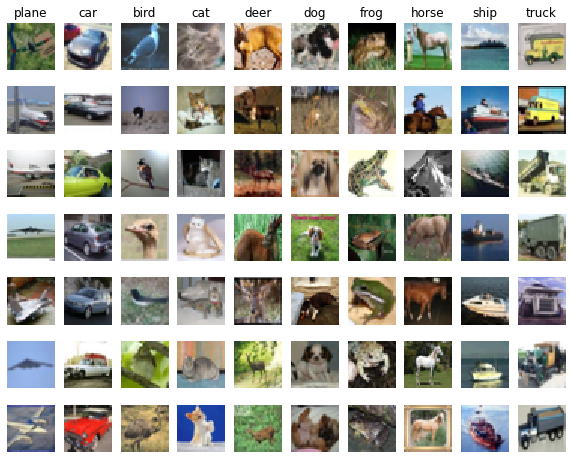

In [10]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [11]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [12]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


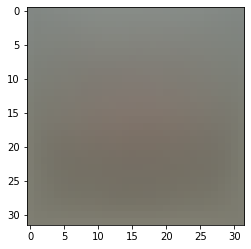

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [13]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

## SVM Classifier

Your code for this section will all be written inside `cs231n/classifiers/linear_svm.py`. 

As you can see, we have prefilled the function `svm_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [15]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

(10,)
loss: 8.466865


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [203]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: -16.378865 analytic: -16.378865, relative error: 2.317948e-11
numerical: 16.768259 analytic: 16.768259, relative error: 2.954430e-11
numerical: -13.332533 analytic: -13.332533, relative error: 1.395734e-11
numerical: 57.160107 analytic: 57.160107, relative error: 6.387787e-12
numerical: 6.238128 analytic: 6.238128, relative error: 3.044334e-11
numerical: 11.771473 analytic: 11.771473, relative error: 3.763051e-11
numerical: -17.288251 analytic: -17.288251, relative error: 2.557945e-12
numerical: -31.152409 analytic: -31.152409, relative error: 9.423372e-13
numerical: 19.311277 analytic: 19.311277, relative error: 4.505770e-11
numerical: -13.264688 analytic: -13.264688, relative error: 1.983098e-11
numerical: 13.313840 analytic: 13.277427, relative error: 1.369383e-03
numerical: 35.648021 analytic: 35.648021, relative error: 3.556499e-12
numerical: 18.516613 analytic: 18.516613, relative error: 1.080409e-11
numerical: 1.800386 analytic: 1.800386, relative error: 5.547957e-11


**Inline Question 1**

It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? How would change the margin affect of the frequency of this happening? *Hint: the SVM loss function is not strictly speaking differentiable*

$\color{blue}{\textit Your Answer:}$ *fill this in.*  

We should think about loss function. Loss function is max(0,score of j - score of true class+1)(delta =1) so if we imagine ploting something similar to the loss function we expect it to be 0 until some point and sj -syi+1 after that point. But the problem is what is actually happening when 0 = score of j - score of true class+1. max (x,y) where x = y is non differentiable. This not a big problem because this is very rare to happen in practice. And since while coding we use: if (score of j - score of true class+1>0) this will just go under else condition. Since this is so rare to happen it won't affect our accuracy.If we change the delta to a higher value it will decrease the frequency of this happening because higher delta means higher scores higher scores means more positive values. (not <=0) and if we dont get x = y this problem doesnt happen.


In [204]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))
# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 9.078198e+00 computed in 0.060447s
Vectorized loss: 9.078198e+00 computed in 0.000000s
difference: 0.000000


In [205]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.077219s
Vectorized loss and gradient: computed in 0.005007s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss. Your code for this part will be written inside `cs231n/classifiers/linear_classifier.py`.

In [206]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 799.807683
iteration 100 / 1500: loss 292.928433
iteration 200 / 1500: loss 109.886448
iteration 300 / 1500: loss 43.360023
iteration 400 / 1500: loss 18.966920
iteration 500 / 1500: loss 10.513120
iteration 600 / 1500: loss 7.667516
iteration 700 / 1500: loss 5.663997
iteration 800 / 1500: loss 5.575773
iteration 900 / 1500: loss 5.767996
iteration 1000 / 1500: loss 5.388184
iteration 1100 / 1500: loss 6.085299
iteration 1200 / 1500: loss 4.960897
iteration 1300 / 1500: loss 5.522337
iteration 1400 / 1500: loss 5.487556
That took 3.017308s


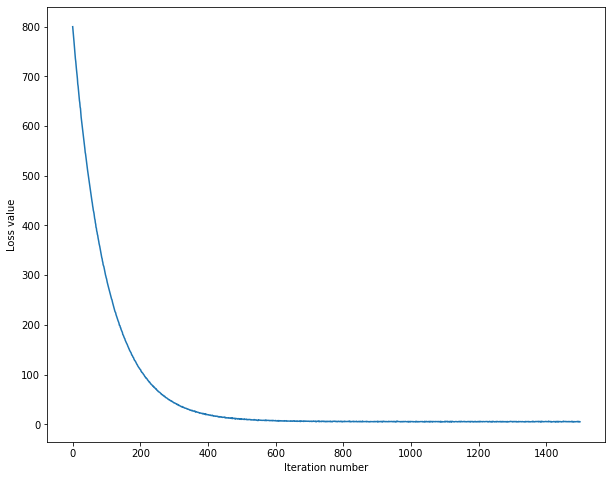

In [207]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [208]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.375980
validation accuracy: 0.396000


In [209]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.39 (> 0.385) on the validation set.

# Note: you may see runtime/overflow warnings during hyper-parameter search. 
# This may be caused by extreme values, and is not a bug.

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [0.5e-7,1e-7,2e-7,3e-7,5e-7,1e-8,5e-5,1e-6,2e-6,4e-6,8e-6]
regularization_strengths = [5e3,2e3,1e3,1e4,2e4,5e4,1e5,2e5]

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for learning_rt in learning_rates:
    for reg_str in regularization_strengths:
            svm = LinearSVM()
            loss_hist = svm.train(X_train, y_train, learning_rate=learning_rt, reg=reg_str,
                      num_iters=1500, verbose=True)
            y_train_pred = svm.predict(X_train)
            training_accuracy = np.mean(y_train == y_train_pred)
            y_val_pred = svm.predict(X_val)
            validation_accuracy = np.mean(y_val == y_val_pred)
            results[(learning_rt,reg_str)] = (training_accuracy,validation_accuracy)
            if(validation_accuracy>best_val):
                best_val = validation_accuracy
                best_svm = svm
            
    
pass

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 174.565122
iteration 100 / 1500: loss 150.655445
iteration 200 / 1500: loss 134.334541
iteration 300 / 1500: loss 122.661312
iteration 400 / 1500: loss 109.431901
iteration 500 / 1500: loss 99.361457
iteration 600 / 1500: loss 90.801102
iteration 700 / 1500: loss 82.234337
iteration 800 / 1500: loss 73.718870
iteration 900 / 1500: loss 66.990057
iteration 1000 / 1500: loss 61.551948
iteration 1100 / 1500: loss 55.972240
iteration 1200 / 1500: loss 51.555024
iteration 1300 / 1500: loss 47.113274
iteration 1400 / 1500: loss 42.503835
iteration 0 / 1500: loss 83.342878
iteration 100 / 1500: loss 73.514896
iteration 200 / 1500: loss 67.836396
iteration 300 / 1500: loss 63.798457
iteration 400 / 1500: loss 62.053072
iteration 500 / 1500: loss 58.683205
iteration 600 / 1500: loss 55.583841
iteration 700 / 1500: loss 53.114246
iteration 800 / 1500: loss 50.311844
iteration 900 / 1500: loss 48.871188
iteration 1000 / 1500: loss 48.444233
iteration 1100 / 1500: loss 45.

iteration 1200 / 1500: loss 6.046834
iteration 1300 / 1500: loss 5.813438
iteration 1400 / 1500: loss 5.551889
iteration 0 / 1500: loss 6193.326852
iteration 100 / 1500: loss 8.296798
iteration 200 / 1500: loss 6.342937
iteration 300 / 1500: loss 6.439041
iteration 400 / 1500: loss 6.494769
iteration 500 / 1500: loss 6.549539
iteration 600 / 1500: loss 6.718698
iteration 700 / 1500: loss 6.421885
iteration 800 / 1500: loss 6.393750
iteration 900 / 1500: loss 6.610744
iteration 1000 / 1500: loss 6.371847
iteration 1100 / 1500: loss 6.408836
iteration 1200 / 1500: loss 6.881027
iteration 1300 / 1500: loss 7.190987
iteration 1400 / 1500: loss 5.953675
iteration 0 / 1500: loss 174.141579
iteration 100 / 1500: loss 110.802750
iteration 200 / 1500: loss 74.350328
iteration 300 / 1500: loss 51.176748
iteration 400 / 1500: loss 35.374582
iteration 500 / 1500: loss 24.478584
iteration 600 / 1500: loss 17.987779
iteration 700 / 1500: loss 13.874226
iteration 800 / 1500: loss 11.021296
iteration 

iteration 1100 / 1500: loss 5.595100
iteration 1200 / 1500: loss 5.451265
iteration 1300 / 1500: loss 5.942000
iteration 1400 / 1500: loss 5.912533
iteration 0 / 1500: loss 3092.149874
iteration 100 / 1500: loss 6.111227
iteration 200 / 1500: loss 5.985836
iteration 300 / 1500: loss 5.846536
iteration 400 / 1500: loss 6.931906
iteration 500 / 1500: loss 6.176876
iteration 600 / 1500: loss 6.213291
iteration 700 / 1500: loss 6.840434
iteration 800 / 1500: loss 6.159972
iteration 900 / 1500: loss 6.644421
iteration 1000 / 1500: loss 6.523489
iteration 1100 / 1500: loss 6.542658
iteration 1200 / 1500: loss 6.095091
iteration 1300 / 1500: loss 5.820487
iteration 1400 / 1500: loss 6.050546
iteration 0 / 1500: loss 6141.095297
iteration 100 / 1500: loss 6.756327
iteration 200 / 1500: loss 7.105834
iteration 300 / 1500: loss 6.944648
iteration 400 / 1500: loss 6.814914
iteration 500 / 1500: loss 6.683553
iteration 600 / 1500: loss 7.146450
iteration 700 / 1500: loss 6.691725
iteration 800 / 1

iteration 900 / 1500: loss 303.914662
iteration 1000 / 1500: loss 280.198175
iteration 1100 / 1500: loss 258.302798
iteration 1200 / 1500: loss 240.249092
iteration 1300 / 1500: loss 221.457564
iteration 1400 / 1500: loss 204.340764
iteration 0 / 1500: loss 1556.666728
iteration 100 / 1500: loss 1271.476995
iteration 200 / 1500: loss 1041.339333
iteration 300 / 1500: loss 851.371665
iteration 400 / 1500: loss 697.033319
iteration 500 / 1500: loss 570.528635
iteration 600 / 1500: loss 467.269576
iteration 700 / 1500: loss 383.374142
iteration 800 / 1500: loss 315.926412
iteration 900 / 1500: loss 258.913431
iteration 1000 / 1500: loss 212.198191
iteration 1100 / 1500: loss 174.533105
iteration 1200 / 1500: loss 143.933373
iteration 1300 / 1500: loss 118.421096
iteration 1400 / 1500: loss 97.809129
iteration 0 / 1500: loss 3080.351923
iteration 100 / 1500: loss 2061.256845
iteration 200 / 1500: loss 1382.159443
iteration 300 / 1500: loss 928.051662
iteration 400 / 1500: loss 622.507871
i

C:\Users\Yagiz\Desktop\StanfordCV\Assignment1\assignment1\cs231n\classifiers\linear_svm.py:98: RuntimeWarning: overflow encountered in double_scalars
  
C:\Users\Yagiz\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\Yagiz\Desktop\StanfordCV\Assignment1\assignment1\cs231n\classifiers\linear_svm.py:98: RuntimeWarning: overflow encountered in multiply
  


iteration 300 / 1500: loss inf
iteration 400 / 1500: loss inf
iteration 500 / 1500: loss inf


C:\Users\Yagiz\Desktop\StanfordCV\Assignment1\assignment1\cs231n\classifiers\linear_svm.py:127: RuntimeWarning: overflow encountered in multiply
  pass
C:\Users\Yagiz\Desktop\StanfordCV\Assignment1\assignment1\cs231n\classifiers\linear_classifier.py:84: RuntimeWarning: invalid value encountered in add
  self.W += - learning_rate * grad


iteration 600 / 1500: loss nan
iteration 700 / 1500: loss nan
iteration 800 / 1500: loss nan
iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
iteration 0 / 1500: loss 3101.522365
iteration 100 / 1500: loss 221169559741621718290982734527420846615702929177912445915110903993614531177110155907823429607533833598590386473327715587425312341149535125439958214298174752375749449190995861947430957520286384128.000000
iteration 200 / 1500: loss inf
iteration 300 / 1500: loss inf


C:\Users\Yagiz\Desktop\StanfordCV\Assignment1\assignment1\cs231n\classifiers\linear_svm.py:95: RuntimeWarning: invalid value encountered in subtract
  margins[range(scores.shape[0]),y] = 0
C:\Users\Yagiz\Desktop\StanfordCV\Assignment1\assignment1\cs231n\classifiers\linear_svm.py:119: RuntimeWarning: invalid value encountered in subtract
  second_step = first_step>0


iteration 400 / 1500: loss nan
iteration 500 / 1500: loss nan
iteration 600 / 1500: loss nan
iteration 700 / 1500: loss nan
iteration 800 / 1500: loss nan
iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
iteration 0 / 1500: loss 6117.552928
iteration 100 / 1500: loss 34508586274828922667896549158124749125026863059494550284018615156250079349383718076271451174627496078615662793009002964955619551683930154471034053113226929297851008720474031373565565381896977900117608008904187314359677633745956610964099602833802409616240279552.000000
iteration 200 / 1500: loss inf
iteration 300 / 1500: loss nan
iteration 400 / 1500: loss nan
iteration 500 / 1500: loss nan
iteration 600 / 1500: loss nan
iteration 700 / 1500: loss nan
iteration 800 / 1500: loss nan
iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 

iteration 200 / 1500: loss 13.032429
iteration 300 / 1500: loss 10.658084
iteration 400 / 1500: loss 13.426361
iteration 500 / 1500: loss 13.386665
iteration 600 / 1500: loss 10.537801
iteration 700 / 1500: loss 17.333947
iteration 800 / 1500: loss 12.535483
iteration 900 / 1500: loss 16.239462
iteration 1000 / 1500: loss 10.786149
iteration 1100 / 1500: loss 8.213292
iteration 1200 / 1500: loss 10.948056
iteration 1300 / 1500: loss 10.022398
iteration 1400 / 1500: loss 9.687034
iteration 0 / 1500: loss 3068.710589
iteration 100 / 1500: loss 10.757930
iteration 200 / 1500: loss 11.060424
iteration 300 / 1500: loss 12.830739
iteration 400 / 1500: loss 13.837345
iteration 500 / 1500: loss 14.912182
iteration 600 / 1500: loss 16.915014
iteration 700 / 1500: loss 14.291671
iteration 800 / 1500: loss 15.942714
iteration 900 / 1500: loss 14.069150
iteration 1000 / 1500: loss 11.302006
iteration 1100 / 1500: loss 17.801707
iteration 1200 / 1500: loss 10.318424
iteration 1300 / 1500: loss 11.3

iteration 1200 / 1500: loss 32.107800
iteration 1300 / 1500: loss 39.848824
iteration 1400 / 1500: loss 26.531701
iteration 0 / 1500: loss 635.960504
iteration 100 / 1500: loss 45.072111
iteration 200 / 1500: loss 39.073583
iteration 300 / 1500: loss 30.895569
iteration 400 / 1500: loss 39.137665
iteration 500 / 1500: loss 38.646635
iteration 600 / 1500: loss 55.341613
iteration 700 / 1500: loss 38.161970
iteration 800 / 1500: loss 43.062451
iteration 900 / 1500: loss 34.606100
iteration 1000 / 1500: loss 29.984323
iteration 1100 / 1500: loss 42.647565
iteration 1200 / 1500: loss 35.996420
iteration 1300 / 1500: loss 60.633139
iteration 1400 / 1500: loss 46.375614
iteration 0 / 1500: loss 1561.761432
iteration 100 / 1500: loss 72.867242
iteration 200 / 1500: loss 88.419647
iteration 300 / 1500: loss 84.196330
iteration 400 / 1500: loss 65.006902
iteration 500 / 1500: loss 70.161231
iteration 600 / 1500: loss 63.213160
iteration 700 / 1500: loss 64.485530
iteration 800 / 1500: loss 82.0

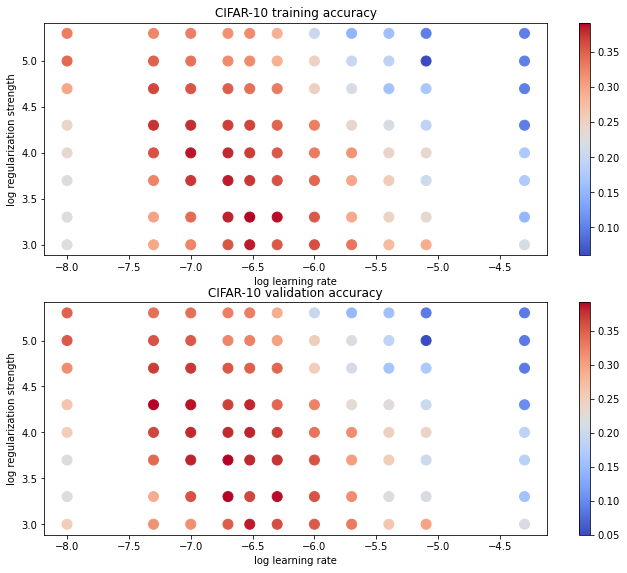

In [216]:
# Visualize the cross-validation results
import math
import pdb

# pdb.set_trace()

x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.tight_layout(pad=3)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [217]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.356000


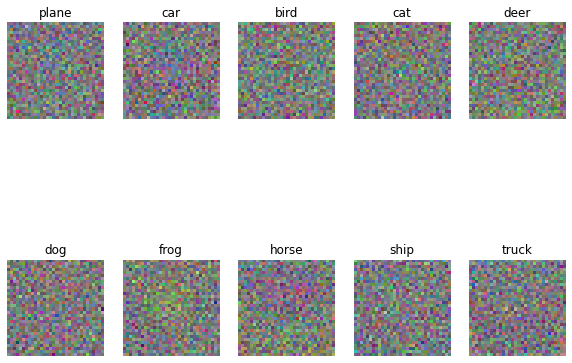

In [218]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

**Inline question 2**

Describe what your visualized SVM weights look like, and offer a brief explanation for why they look the way they do.

$\color{blue}{\textit Your Answer:}$ *fill this in*  
My Visualized SVM weights didnt actually look like the real images. Which makes sense because those arent real images.
They are created this way because they prioritized some features more than others. But it is also quite common for them to look like the class itself(even though it isn't actually the case in my situation). Because scores are simply pixel values for each classes. This images are something like average images. Images can have lots of different features even if they are they are the same class. Therefore it is like mix up.
